<a href="https://colab.research.google.com/github/supanat-tht/tbla3-staff/blob/main/Week-03-Exercise01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://drive.google.com/uc?export=view&id=1DXUVHxd4t15mfuqMgMCLnsP4jWVI5EWz)
---

<br>
© 2022 Copyright The University of New South Wales - CRICOS 00098G

**Author**: Oscar Perez-Concha: o.perezconcha@unsw.edu.au

**Contributors/Co-authors**: Marta Fredes-Torres, Zhisheng (Sandy) Sa and Matthew Sainsbury-Dale.

# Chapter 3: Model Evaluation and Improvement
# Exercise 1: Cross-Validation for (just) performance evaluation purposes

<b>Goal/Research question:</b> <font color=green> <b> To build a predictive algorithm and predict readmission to hospital 30 days after discharge. In particular, this exercise will assess how well our predictive algorithm generalises to unseen data. </b></font>


# 1. Introduction

 1. To become familiar with cross-validation for **model evaluation** - assessing generalisation to unseen data <font color=green>**(Step 5 of the ML work-flow)**</font>
 2. Bear in mind, that cross-validation can be used to tune hyper-parameters as well, but we are not going to do that in this exercise.

Useful readings:
1. [A gentle introduction to k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/)
2. [How to train a final machine learning model](https://machinelearningmastery.com/train-final-machine-learning-model/)

It aligns with all of the learning outcomes of our course: 

1.	Distinguish a range of task specific machine learning techniques appropriate for Health Data Science.
2.	Design machine learning tasks for Health Data Science scenarios.

**NB Nomeclature:**
Training, Validation and Test Set. 

* The training set, used to train the model
* The validation set, used to evaluate model performance and adjust model hyper-parameters accordingly (for example, the $\alpha$ for Ridge Regression). Therefore, the validation set is used as an intermediate step. 
* The test set, used for final model evaluation. Some textbooks use "the term validation set" for what we call "test set".

Follow the instructions given and if you have any questions, please use the **Comment section** in **Open Learning**. 

In [1]:
import sys
import numpy as np
import pandas as pd
from IPython.display import display


In [2]:
# Ignore only Future Warnings
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Mount Google Drive
# We do not need to run this cell if you are not running this notebook in Google Colab

if 'google.colab' in str(get_ipython()):
    from google.colab import drive # import drive from Gogle colab
    root = '/content/drive'     # default location for the drive
    # print(root)                 # print content of ROOT (Optional)
    drive.mount(root)
else:
    print('Not running on CoLab')

Mounted at /content/drive


In [4]:
from pathlib import Path

if 'google.colab' in str(get_ipython()):
    # EDIT THE PROJECT PATH IF DIFFERENT WITH YOUR ONE
    project_path = Path(root) / 'MyDrive' / 'HDAT9500' / 'week03'

    # OPTIONAL - set working directory according to your google drive project path
    # import os
    # Change directory to the location defined in project_path
    # os.chdir(project_path)
else:
    project_path = Path()

# 2. Docstring: 

Create a docstring with the variables and constants that you will use in this exercise (data dictionary) and the purpose of your program. It is expected that you choose informative variable names and document your program (both docstrings and comments).

<b> Write the answer here:</b>
#####################################################################################################################

(double-click here)


#####################################################################################################################

# 3. Load the diabetes data set

Please note that we already cleaned and created dummy variables for the diabetes dataset. In the Exercise 1 of week 2 we saved this 'prepared' dataset using `pickle`. Now, we will load this data using `pickle` ([more information](https://docs.python.org/3/library/pickle.html))

In [7]:
import pickle
from pathlib import Path

# Load dataset with dummy variables and already cleaned in Exercise 1 of Chapter 2
pickle_path = Path(root) / 'MyDrive' / 'HDAT9500' /'week02'/'hospital_data.pickle' 

with open(pickle_path, 'rb') as data:
    hospital = pickle.load(data)
    
hospital.head()

,los,Age,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_emergency,number_inpatient,number_outpatient,sex_Female,...,admission_source_grouped_Other,admission_source_grouped_Physician Referral,admission_source_grouped_Transfer from SNF,admission_source_grouped_Transfer from another health care facility,admission_type_grouped_Elective,admission_type_grouped_Emergency,admission_type_grouped_Not Available/Null,admission_type_grouped_Trauma Centre,admission_type_grouped_Urgent,readmission
0,2,79,9,38,0,12,0,0,0,1,...,0,0,0,0,1,0,0,0,0,no
1,5,59,8,49,0,16,0,0,0,0,...,0,0,0,0,1,0,0,0,0,no
2,2,33,5,62,0,15,1,0,1,1,...,0,0,0,0,1,0,0,0,0,no
3,6,42,9,77,0,30,0,0,0,1,...,0,0,0,0,1,0,0,0,0,no
4,1,62,7,13,5,6,0,0,0,0,...,0,0,0,0,1,0,0,0,0,no


In [8]:
hospital.columns

Index(['los', 'Age', 'number_diagnoses', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_emergency',
       'number_inpatient', 'number_outpatient', 'sex_Female', 'sex_Male',
       'max_glu_serum_>200', 'max_glu_serum_>300', 'max_glu_serum_None',
       'max_glu_serum_Norm', 'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_None',
       'A1Cresult_Norm', 'group_name_1_Blood_&_immune', 'group_name_1_CNS',
       'group_name_1_Cancer', 'group_name_1_Cardiac_&_circulatory',
       'group_name_1_Digestive', 'group_name_1_Endocrine',
       'group_name_1_Infectious', 'group_name_1_Mental_&_Substance',
       'group_name_1_Other', 'group_name_1_Respiratory',
       'group_name_2_Blood_&_immune', 'group_name_2_CNS',
       'group_name_2_Cancer', 'group_name_2_Cardiac_&_circulatory',
       'group_name_2_Digestive', 'group_name_2_Endocrine',
       'group_name_2_Infectious', 'group_name_2_Mental_&_Substance',
       'group_name_2_Other', 'group_name_2_Respiratory',
       

# 4. Scaling of the Features 

In order to understand their relative magnitude, we are going to represent all features on the same scale . In particular, we are going to standardise our features. We can scale our features in many ways, and standardisation is just one of them. 

**In this first part of the exercise (section 3), we are going to just <font color=green>visualise</font> the standardised features, but we are not going to feed them into a model yet.** 

#### Splitting the feature variables from the response

In [9]:
# Dividing my dataset in X and y (outcome)
X = hospital.drop(columns=['readmission'], axis=1)
y = hospital['readmission']

In [10]:
# Sanity check
display(X[:5])
X.shape

,los,Age,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_emergency,number_inpatient,number_outpatient,sex_Female,...,admission_source_grouped_Not available/Null,admission_source_grouped_Other,admission_source_grouped_Physician Referral,admission_source_grouped_Transfer from SNF,admission_source_grouped_Transfer from another health care facility,admission_type_grouped_Elective,admission_type_grouped_Emergency,admission_type_grouped_Not Available/Null,admission_type_grouped_Trauma Centre,admission_type_grouped_Urgent
0,2,79,9,38,0,12,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,5,59,8,49,0,16,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,33,5,62,0,15,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,6,42,9,77,0,30,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,62,7,13,5,6,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


(69267, 69)

In [11]:
# Sanity check
display(y[:5])
y.shape

0    no
1    no
2    no
3    no
4    no
Name: readmission, dtype: object

(69267,)

#### Visualising the first ten features

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

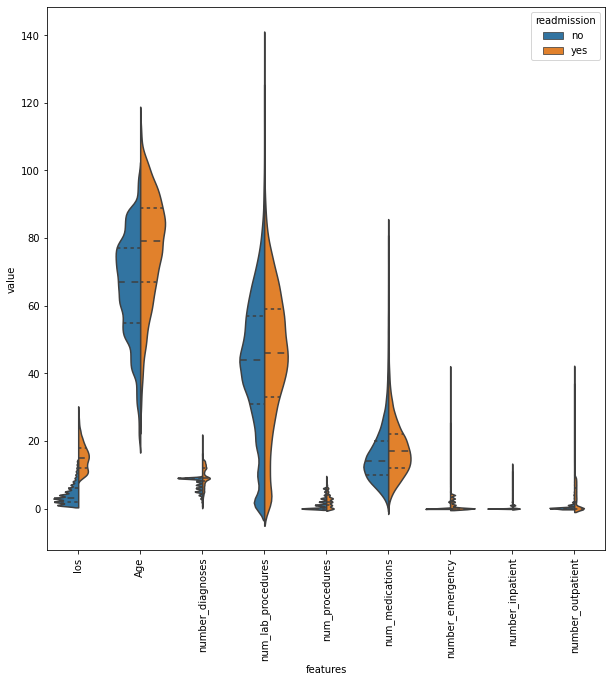

In [12]:
# visualising first ten features
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.concat([y,X.iloc[:, 0:9]],axis=1)
data = pd.melt(data,id_vars="readmission", var_name="features", value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="readmission", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

As we can see, all these features vary in magnitudes. What could we do?  

**Scaling the features** ([More information](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e))

Your dataset will often contain features that vary in magnitudes, units and ranges. This may be a problem if, for example, our machine learning algorithm uses Eucledian distance between two data points in their computations for the loss function (MSE in the case of linear regression). 


**Let's visualise these first 10 features after scaling them.**

Standardise features by removing the mean and scaling to unit variance:


The standard score of a sample x is calculated as:

\begin{align*}
z = (x - \mu) / s
\end{align*}

where $\mu$ is the mean of the training samples, and s is the standard deviation of the training samples.

[Read `StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

<font color=green> Remember that when we apply the `StandardScaler()`, we have to calculate the mean ($\mu$) and standard deviation (s) of the training set only using `scaler.fit(X)`. Once those values are calculated, we standardise the training and test sets separately using the  mean and standard deviation of the training set.   </font>
    
<font color=green>  This first part of the exercise is just for visual purposes, so we are going to standardise the whole data.</font>

In [14]:
# rescale the training data, or the whole data in this case. Just for visual purposes
scaler.fit(X)
X_scaled_temp = scaler.transform(X)

In [15]:
# create DataFrame from X_scaled_temp array that contains the column names of the original dataset
X_scaled=pd.DataFrame(X_scaled_temp, columns = list(X.columns.values))

In [16]:
# Sanity check
X_scaled[:5]

,los,Age,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_emergency,number_inpatient,number_outpatient,sex_Female,...,admission_source_grouped_Not available/Null,admission_source_grouped_Other,admission_source_grouped_Physician Referral,admission_source_grouped_Transfer from SNF,admission_source_grouped_Transfer from another health care facility,admission_type_grouped_Elective,admission_type_grouped_Emergency,admission_type_grouped_Not Available/Null,admission_type_grouped_Trauma Centre,admission_type_grouped_Urgent
0,-0.792994,0.725668,0.592962,-0.256544,-0.867039,-0.485002,-0.320163,-0.340009,-0.383211,0.938169,...,-0.265496,-0.037832,-0.544165,-0.072179,-0.220981,1.361709,-0.773568,-0.342727,-0.015668,-0.452422
1,-0.220492,-0.512782,0.163160,0.295520,-0.867039,-0.007517,-0.320163,-0.340009,-0.383211,-1.065906,...,-0.265496,-0.037832,-0.544165,-0.072179,-0.220981,1.361709,-0.773568,-0.342727,-0.015668,-0.452422
2,-0.792994,-2.122768,-1.126244,0.947960,-0.867039,-0.126888,0.811302,-0.340009,0.111328,0.938169,...,-0.265496,-0.037832,-0.544165,-0.072179,-0.220981,1.361709,-0.773568,-0.342727,-0.015668,-0.452422
3,-0.029658,-1.565465,0.592962,1.700775,-0.867039,1.663680,-0.320163,-0.340009,-0.383211,0.938169,...,-0.265496,-0.037832,-0.544165,-0.072179,-0.220981,1.361709,-0.773568,-0.342727,-0.015668,-0.452422
4,-0.983828,-0.327015,-0.266641,-1.511236,1.811693,-1.201229,-0.320163,-0.340009,-0.383211,-1.065906,...,-0.265496,-0.037832,-0.544165,-0.072179,-0.220981,1.361709,-0.773568,-0.342727,-0.015668,-0.452422


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

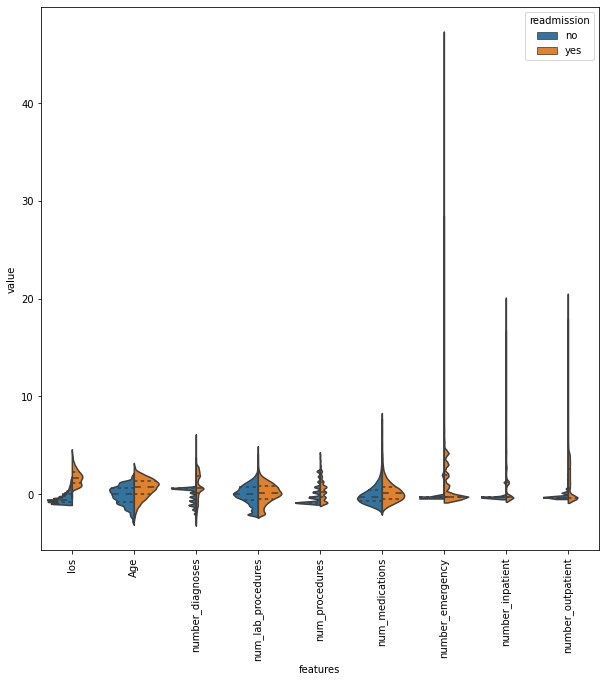

In [17]:
# visualising first ten features of our X_scaled dataset
data = pd.concat([y,X_scaled.iloc[:, 0:9]],axis=1)
data = pd.melt(data,id_vars="readmission", var_name="features", value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="readmission", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

As you can see, all the features are at the same scale now and it will be easier for the ML algorithm to fit a model to predict the correct outcome.

Nevertheless, the outliers do not allow us to see the features in detail. Let's zoom in by plotting only values smaller than a certain threshold. Feel free to change this threshold.
See [seaborn documentation](https://seaborn.pydata.org/generated/seaborn.violinplot.html) for more information.

In [18]:
zoom_threshold=3

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

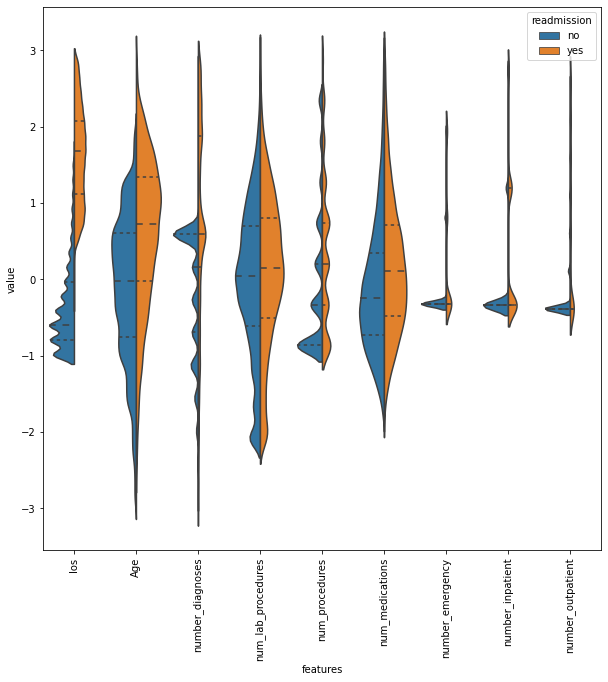

In [19]:
# visualising first ten features of our X_scaled dataset
data = pd.concat([y,X_scaled.iloc[:, 0:9]],axis=1)
data = pd.melt(data,id_vars="readmission", var_name="features", value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="readmission", data=data[data.value<zoom_threshold],split=True, inner="quart")
plt.xticks(rotation=90)

# 5. Cross-Validation for evaluation of our ML model
Up to now, we have only used the training-test approach to <b>evaluate our models</b>. As you are aware, the training-test approach involves **randomly** partitioning the data into two sets, one for training and one for testing (e.g. 80/20 partition in a random way). The advantage of the training-test approach is that it is simple to understand and implement. However, estimates of test error can be highly variable, with dependence on which records are randomly selected for training and testing.


Here, we will introduce another related **method of model performance evaluation** known as "k-fold cross-validation". In k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples, called **folds**. Of the k folds, a single fold is designated as the test set, and the remaining k-1 folds are used as training data. Now, here is where the method differs from the training-test approach. Previously, we would train a single model on a "training fold", evaluate on the "test fold", and then finish. Instead, now we train k models, each with a different test fold, and then average the performance to yield our final accuracy. It is common to choose k as either 5 or 10.<p>
    
To illustrate, consider the case of 5-fold cross-validation. Here, we split the data into 5 equally sized folds. Let's call them fold_1, fold_2, fold_3, fold_4, and fold_5. Then, choose one of the folds as the first test fold, and the remaining 4 folds are the training folds. Let's say we choose fold_1 for the first test fold, so we have fold_2, fold_3, fold_4, and fold_5 for training. Now, train and evaluate the first model using these folds. Let's call this model and its results model_1.

<p> Now, we swap the test fold of fold_1 with a training fold that has not previously been used for testing. Let's say we swap fold_1 with fold_2. This means we have fold_2 as our new test fold, and we have fold_1, fold_3, fold_4, and fold_5 for training. Now, train and evaluate the second model and call it model_2.<p>

Repeat this process until we have used all 5 of our folds for testing exactly once. We would now have 5 models and their associated performance evaluation results (either F1 score, accuracy,...), model_1, model_2, model_3, model_4, and model_5. We then average these results. 
    
I would like you to remember that:
    
1. Cross-validation is just a method to better estimate the performance of a model.
2. Cross-validation can be used either:

a. To just compute the performance of a model using different partitions of training and test sets and/or different hyper-parameters.

b. To compute the performance of a model using different partitions of training and test sets and/or different hyper-parameters AND to select the best resulting model out of that process. We will see that in the next exercise. 

## 5.1 Cross-Validation: standard logistic regression

Here we will demonstrate k-fold cross-validation for our data, to evaluate the performance of standard logistic regression with class weights (option 2a above). To do so, we use [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). This method takes as inputs the model we wish to fit, the features we will use as predictors, and the response variable. The output is an array of model performance scores. <p> 
    **Note** that the cross-validation used is a special kind known as **stratified** k-fold cross-validation. **Stratified** means that each fold maintains the proportion of 1 and 0, YES or NO cases as in the output of the original data. 
    
Read the [scikit-learn website on cv](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

**For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, Stratified KFold is used. In all other cases, KFold is used.**

**Note:<font color=green> very very very important </font>:
Be mindful that cross-validation is <font color=green>not</font> a way to build a model, it is only a<font color=green> method to evaluate</font> the performance of a given model in order to test or validate its generalisation.**

### 5.1.1 Binarise the response
In this case, we will use "y_binary" vector. Therefore, the classes in our dictionary will be 0 and 1 (instead of 'no' and 'yes').

In [20]:
# Sanity Checks:
print('******************************************')
print('y - Yes values =', sum(i =='yes' for i in y))
print('y - No values =', sum(i =='no' for i in y))
print('******************************************\n')

# Create y_binary
y_binary = [0 if x=='no' else 1 for x in y]

# Sanity Checks:
print('\n******************************************')
print('y_binary - 1 values =', sum(i ==1 for i in y_binary))
print('y_binary - 0 values =', sum(i ==0 for i in y_binary))
print('******************************************')

******************************************
y - Yes values = 11919
y - No values = 57348
******************************************


******************************************
y_binary - 1 values = 11919
y_binary - 0 values = 57348
******************************************


## 5.2 Cross-Validation + Pipelines:

Recall that for regularisation to be meaningful, we require the features to be <b>standardised</b>, and that we must fit the standardiser on the <b>*training set only*</b>, and then apply it to the test set. With cross-validation, the training and test set changes at each iteration. This means we must fit the scaler for each new training set in each iteration. We will achieve this by using a **pipeline**.<p> 
        **Pipelines** allow us to sequentially perform a list of transformations and a final estimator. In our case, we wish to apply the standardisation transformation, and then the logistic regression estimator.<p>
            If we use a **pipeline** to make a cross-validated estimator using cross_val_score, then the StandardScaler will estimate the parameters for centering and rescaling to unit variance only on the training folds. When evaluating the pipeline on the test fold, the StandardScaler will use the stored means and standard deviations, and subtract the training mean from the test set and divide the result by the training standard deviation. So even in the pipeline, the StandardScaler will not use the test set in any way to determine mean and variance of the data.
  

To read about Pipelines:
1. [sckit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
2. [An simple example of pipeline](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)


### 5.2.1. Define our pipeline and then use cross-validation


We know that the diabetes dataset is an imbalanced data set. In this exercise, we are introducing some weights associated with classes for readmission 'YES' and 'NO'. The weights can be used to correct the imbalance in the data set; they are the importance, the weight that you give to each record with a readmission=YES or readmission=NO. 


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 

In [22]:
# Scaler/Standardisation
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()

# Classification Model
class_weight_dict={0:0.4, 1:0.6}
Log_Reg = LogisticRegression(C = 0.5, penalty = 'l1',  class_weight = class_weight_dict, solver='liblinear')

# PipeLine: 
pipe = Pipeline([('Transform', Scaler), ('Estimator', Log_Reg)])

We are going to start using the function `cross_val_score`, which is from the scikit-learn library. Read more on the [API (application programming interface) documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [23]:
# Cross-validation (cross_val_score) + Pipeline, accuracy performance metric, and features with standardisation (with_standardisation)
# Be patient, it takes some time :-):
from sklearn.model_selection import cross_val_score 
cv_acc_with_standardisation = cross_val_score(pipe, X, y_binary, cv = 3)

Check the field "scoring" from [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
). As you can read, only a single metric is permitted.
If this field is "None", the estimator’s default scorer (if available) is used.

For LogisticRegression in scikit learn, the default scorer is "accuracy". [Check the section "methods", the field "score"](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [24]:
print("Cross-validation accuracy scores:\n {}".format(cv_acc_with_standardisation))
print("Average cross-validation score: {:.4f}".format(cv_acc_with_standardisation.mean()))

Cross-validation accuracy scores:
 [0.97539954 0.96626099 0.97089523]
Average cross-validation score: 0.9709


### 5.2.2 Cross_validate + standardisation

Let's repeat the analysis using the function <font color=green>`sklearn.model_selection.cross_validate`</font> with standardisation process. **The function <font color=green>[`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html?highlight=cross_validate#sklearn.model_selection.cross_validate)</font> allows us to use more than one metric at a time.**

<div class="alert alert-block alert-success">**Start Activity**</div>

### <font color='brown'> Question:  Write the code that calculates the 5-CV using "cross_validate"+ standardised features with Pipelines. Compute accuracy, recall, precision, auc and f1 scores.  </font>

Documentation:

* [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate)

* [`metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

* [`f1 score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [26]:
# Write Python code here:
cv_acc_with_standardisation = cross_val_score(pipe, X, y_binary, cv = 5)
print("Cross-validation accuracy scores:\n {}".format(cv_acc_with_standardisation))
print("Average cross-validation score: {:.4f}".format(cv_acc_with_standardisation.mean()))

Cross-validation accuracy scores:
 [0.98397575 0.9725711  0.9672995  0.97069227 0.97415722]
Average cross-validation score: 0.9737


© 2022 Copyright The University of New South Wales - CRICOS 00098G